# Upward continuation of gravity data

This code uses the potential-field data computed in the notebook `aula_5d_dados_sinteticos_grav.ipynb`.

### Things we have to import

In [1]:
import numpy as np

In [2]:
from numpy.polynomial.polynomial import polyvander2d

In [3]:
import matplotlib.pyplot as plt

In [4]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [5]:
import time

In [6]:
import pickle

In [7]:
from gravmag import data_structures, utils, aux_vedo, constants, check, transforms, inverse_distance, convolve, filters, eqlayer
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf

In [8]:
import vedo

In [9]:
# set the backend for vedo
vedo.settings.default_backend= 'vtk'
#vedo.settings.default_backend= '2d'

In [10]:
def model_cut(model, pmin, pmax):
    check.are_rectangular_prisms(model)
    check.is_integer(x=pmin, positive=True, include_zero=True)
    check.is_integer(x=pmax, positive=True, include_zero=True)
    if pmin >= pmax:
        raise ValueError('pmin must be greater than pmax')
    nprisms = model['x1'].size
    if pmin >= nprisms:
        raise ValueError('pmin must be smaller than num. of model prisms')
    if pmax >= nprisms:
        raise ValueError('pmax must be smaller than num. of model prisms')
    selected_model = dict()
    for element in model.keys():
        selected_model[element] = model[element][pmin:pmax+1]
    return selected_model

### Load the model

In [11]:
model = pickle.load(open('aula_5d/synthetic_bodies.pickle', 'rb'))

In [12]:
# model properties
print("(xmin, xmax) = ({:.3f}, {:.3f}) m".format(model['prisms']['x1'].min(), model['prisms']['x2'].max()))
print("(ymin, ymax) = ({:.3f}, {:.3f}) m".format(model['prisms']['y1'].min(), model['prisms']['y2'].max()))
print("(top min, top max) = ({:.3f}, {:.3f}) m".format(model['prisms']['z1'].min(), model['prisms']['z1'].max()))
print("(bottom min, bottom max) = ({:.3f}, {:.3f}) m".format(model['prisms']['z2'].min(), model['prisms']['z2'].max()))
print("number of prisms: {}".format(model['prisms']['x1'].size))

(xmin, xmax) = (-7145.517, 6935.019) m
(ymin, ymax) = (-5789.988, 8247.407) m
(top min, top max) = (0.000, 1000.000) m
(bottom min, bottom max) = (112.448, 1500.000) m
number of prisms: 305


### Load the data points

In [13]:
data_points = pickle.load(open('aula_5d/data_points.pickle', 'rb'))

In [14]:
data_points_cont = pickle.load(open('aula_5d/data_points_cont.pickle', 'rb'))

In [15]:
# number of points along x and y
print('n. data = {}'.format(data_points['shape'][0]*data_points['shape'][1]))

# grid spacing
data_dx, data_dy = data_structures.grid_xy_spacing(area=data_points['area'], shape=data_points['shape'])
print('dx = {:.3f} m | dy = {:.3f} m'.format(data_dx, data_dy))

n. data = 4900
dx = 202.899 m | dy = 202.899 m


In [16]:
X, Y = data_structures.grid_xy_to_full_matrices_view(
    x=data_points['grid']['x'],
    y=data_points['grid']['y'],
    shape=data_points['shape']
)

### Load the true residual data (gravity disturbance)

In [17]:
gravity_data = pickle.load(open('aula_5d/gravity_data.pickle', 'rb'))

In [18]:
gravity_data_cont = pickle.load(open('aula_5d/gravity_data_cont.pickle', 'rb'))

### Load the estimated residual data (gravity disturbance)

In [19]:
estimated_residual = pickle.load(open('aula_8a/residual_robust.pickle', 'rb'))

### Set an equivalent layer

In [20]:
# set the layer vertical coordinate
z_layer = 200

In [21]:
# compute the SEDM
R2 = inverse_distance.sedm_BTTB(
    data_grid = data_points['grid'], 
    delta_z = z_layer - data_points['grid']['z'],
    grid_orientation = gravity_data['grid_orientation']
)

In [22]:
# Compute the vertical gradient of inverse distance function
Gradient = inverse_distance.grad_BTTB(
    data_grid = data_points['grid'],
    delta_z = z_layer - data_points['grid']['z'],
    SEDM = R2,
    grid_orientation = gravity_data['grid_orientation'],
    components=['z']
)

In [23]:
# compute the eigenvalues matrix
L_Gradient = convolve.eigenvalues_BCCB(BTTB_metadata=Gradient['z'])

## Estimate the equivalent layer - true residual data

In [24]:
# estimate the equivalent layer
convergence, layer = eqlayer.method_iterative_deconvolution_TOB20(
    eigenvalues_matrices=[L_Gradient],
    data_vectors=[gravity_data['gz']],
    epsilon=1e-7,
    ITMAX=200
)

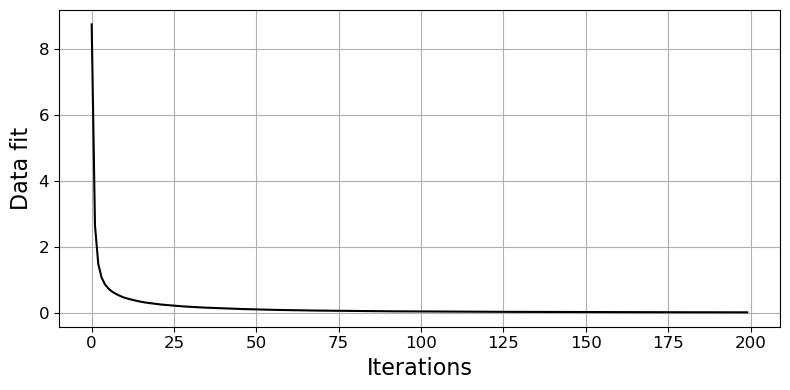

In [25]:
fig, ax = plt.subplots(figsize=(8,4))

iterations = [i for i in range(len(convergence))]
ax.plot(
    iterations, convergence, linestyle='-', c='k', alpha=1, markersize=4
)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Iterations', fontsize=16)
ax.set_ylabel('Data fit', fontsize=16)
ax.grid(True)
plt.tight_layout()
plt.show()

## Compute the predicted data

In [26]:
predicted_data = {
    'gz': convolve.product_BCCB_vector(
        eigenvalues = L_Gradient,
        ordering = 'row',
        v = layer
    )
}

## Compute the upward continuation

In [27]:
# compute the SEDM
R2 = inverse_distance.sedm_BTTB(
    data_grid = data_points_cont['grid'], 
    delta_z = z_layer - data_points_cont['grid']['z'],
    grid_orientation = gravity_data['grid_orientation']
)

In [28]:
# Compute the vertical gradient of inverse distance function
Gradient = inverse_distance.grad_BTTB(
    data_grid = data_points_cont['grid'],
    delta_z = z_layer - data_points_cont['grid']['z'],
    SEDM = R2,
    grid_orientation = gravity_data_cont['grid_orientation'],
    components=['z']
)

In [29]:
# compute the eigenvalues matrix
L_Gradient = convolve.eigenvalues_BCCB(BTTB_metadata=Gradient['z'])

In [30]:
predicted_data_cont = {
    'gz': convolve.product_BCCB_vector(
        eigenvalues = L_Gradient,
        ordering = 'row',
        v = layer
    )
}

In [31]:
# Compute the vertical gradient of inverse distance function
Tensor = inverse_distance.grad_tensor_BTTB(
    data_grid = data_points_cont['grid'],
    delta_z = z_layer - data_points_cont['grid']['z'],
    SEDM = R2,
    grid_orientation = gravity_data_cont['grid_orientation'],
    components=['zz']
)

In [32]:
# compute the eigenvalues matrix
L_Tensor = convolve.eigenvalues_BCCB(BTTB_metadata=Tensor['zz'])

In [33]:
predicted_data_cont['zz'] = convolve.product_BCCB_vector(
    eigenvalues = L_Tensor,
    ordering = 'row',
    v = 1e4*layer
)

## Plot the results

In [34]:
names = [
    'true residual', 'predicted eql data', 'difference',
    'true cont. data', 'predicted eql cont. data', 'difference'
]
labels = [
    '(a)', '(b)', '(c)',
    '(d)', '(e)', '(f)'
]

In [35]:
mosaic_elements = [
    'a', 'b', 'c', 
    'd', 'e', 'f'
]

In [36]:
color = 'k'#3*(0.4,)

In [37]:
ranges_data = np.max(np.abs([predicted_data['gz'], gravity_data['gz']]))
ranges_data_cont = np.max(np.abs([gravity_data_cont['gz'], predicted_data_cont['gz']]))

ranges = [
    ranges_data, ranges_data, np.max(np.abs(predicted_data['gz'] - gravity_data['gz'])),
    ranges_data_cont, ranges_data_cont, np.max(np.abs(predicted_data_cont['gz'] - gravity_data_cont['gz'])),
]

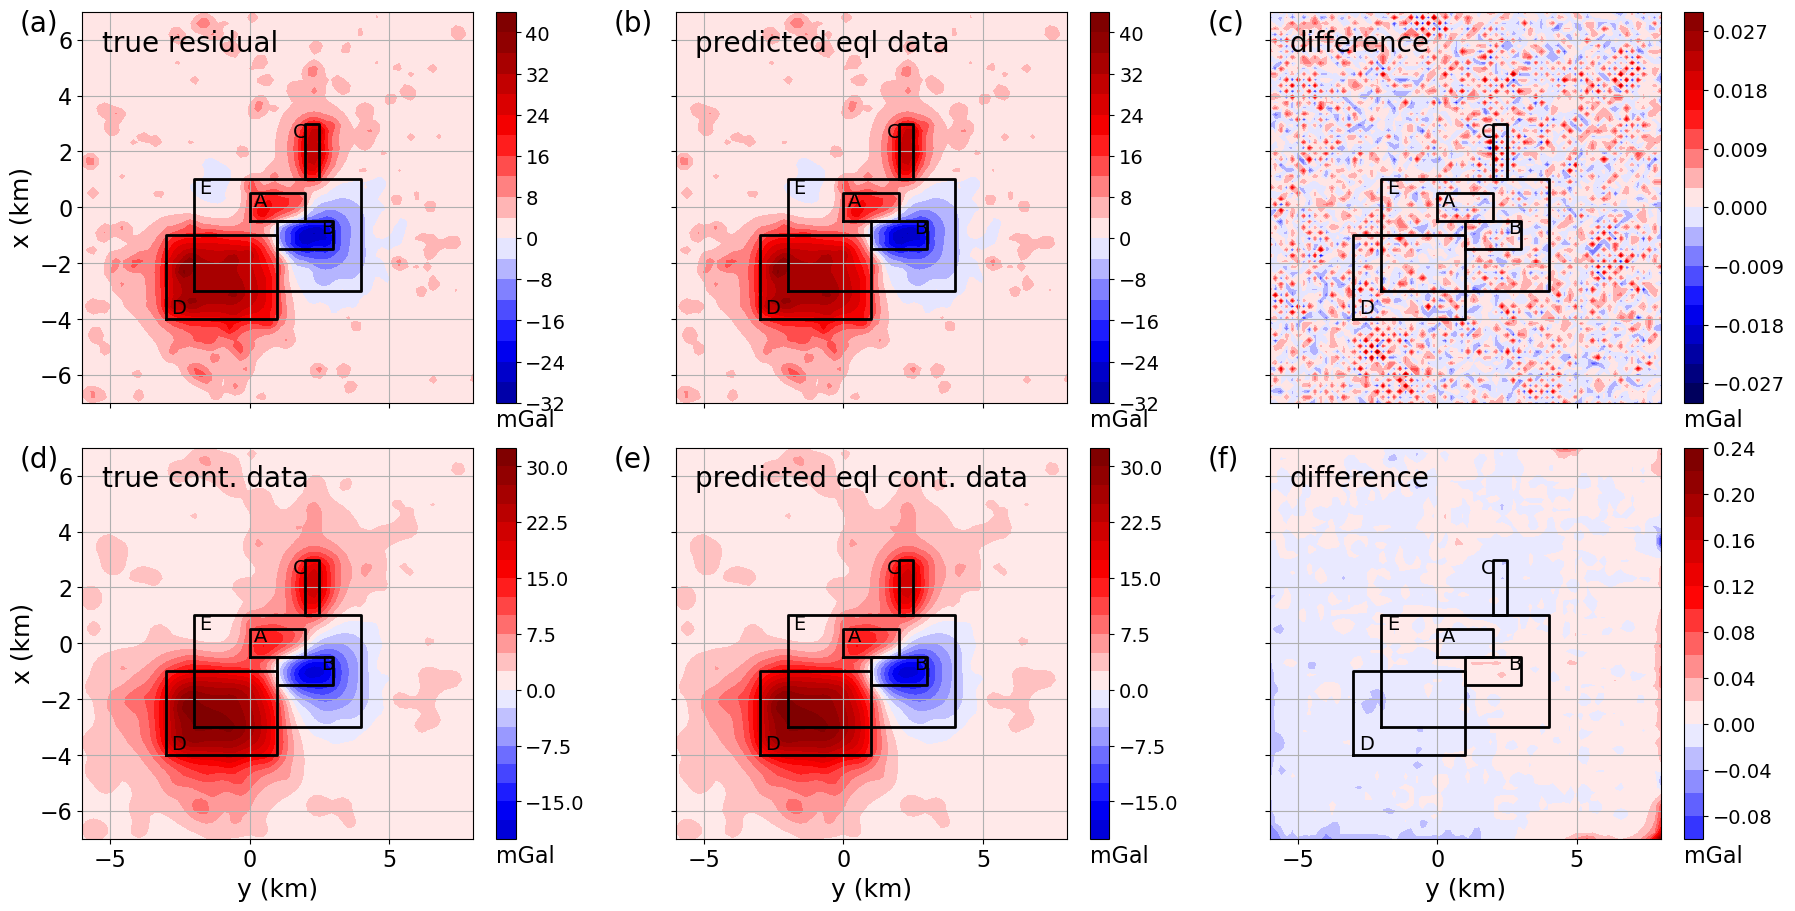

In [38]:
fig = plt.figure(layout= 'constrained', figsize=(18,9))
mosaic = fig.subplot_mosaic('''
                            abc
                            def
                            ''', sharex=True, sharey=True)

for (element, field, name, label, ranges_field) in zip(
    mosaic_elements, 
    [
        gravity_data['gz'], predicted_data['gz'], predicted_data['gz'] - gravity_data['gz'],
        gravity_data_cont['gz'], predicted_data_cont['gz'], predicted_data_cont['gz'] - gravity_data_cont['gz']
    ], 
    names, 
    labels,
    ranges
):

    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(Y*0.001, X*0.001, 
                     data_structures.grid_xy_full_flatten_to_matrix(
                         data=field,
                         grid_orientation=gravity_data['grid_orientation'],
                         shape=data_points['shape']
                     ), 20, 
                     cmap='seismic', vmin=-ranges_field, vmax=ranges_field)
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_xlabel('mGal', fontsize=16, loc='left')
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)
    ax.annotate(name, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=20)
    plf.model_boundaries(
        ax,
        model=model_cut(model['prisms'], pmin=0, pmax=4),
        color=color,
        style='-',
        width='2'
    )
    ax.annotate(text='A', xy=(0.15, 0.05), fontsize=14, color=color)
    ax.annotate(text='B', xy=(2.55, -0.95), fontsize=14, color=color)
    ax.annotate(text='C', xy=(1.55, 2.50), fontsize=14, color=color)
    ax.annotate(text='D', xy=(-2.80, -3.80), fontsize=14, color=color)
    ax.annotate(text='E', xy=(-1.80, 0.50), fontsize=14, color=color)

for element in ['a', 'd']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)

for element in ['d','e','f']:
    mosaic[element].set_xlabel('y (km)', fontsize=18)

plt.show()

In [39]:
names = [
    'true residual', 'predicted eql data', 'difference',
    'true cont. data', 'predicted eql cont. data', 'difference'
]
labels = [
    '(a)', '(b)', '(c)',
    '(d)', '(e)', '(f)'
]

In [40]:
mosaic_elements = [
    'a', 'b', 'c', 
    'd', 'e', 'f'
]

In [41]:
unities = [
    'mGal', 'mGal', 'mGal', 
    'Eo', 'Eo', 'Eo'
]

In [42]:
color = 'k'#3*(0.4,)

In [43]:
ranges_data = np.max(np.abs([predicted_data['gz'], gravity_data['gz']]))
ranges_data_cont = np.max(np.abs([gravity_data_cont['zz'], predicted_data_cont['zz']]))

ranges = [
    ranges_data, ranges_data, np.max(np.abs(predicted_data['gz'] - gravity_data['gz'])),
    ranges_data_cont, ranges_data_cont, np.max(np.abs(predicted_data_cont['zz'] - gravity_data_cont['zz'])),
]

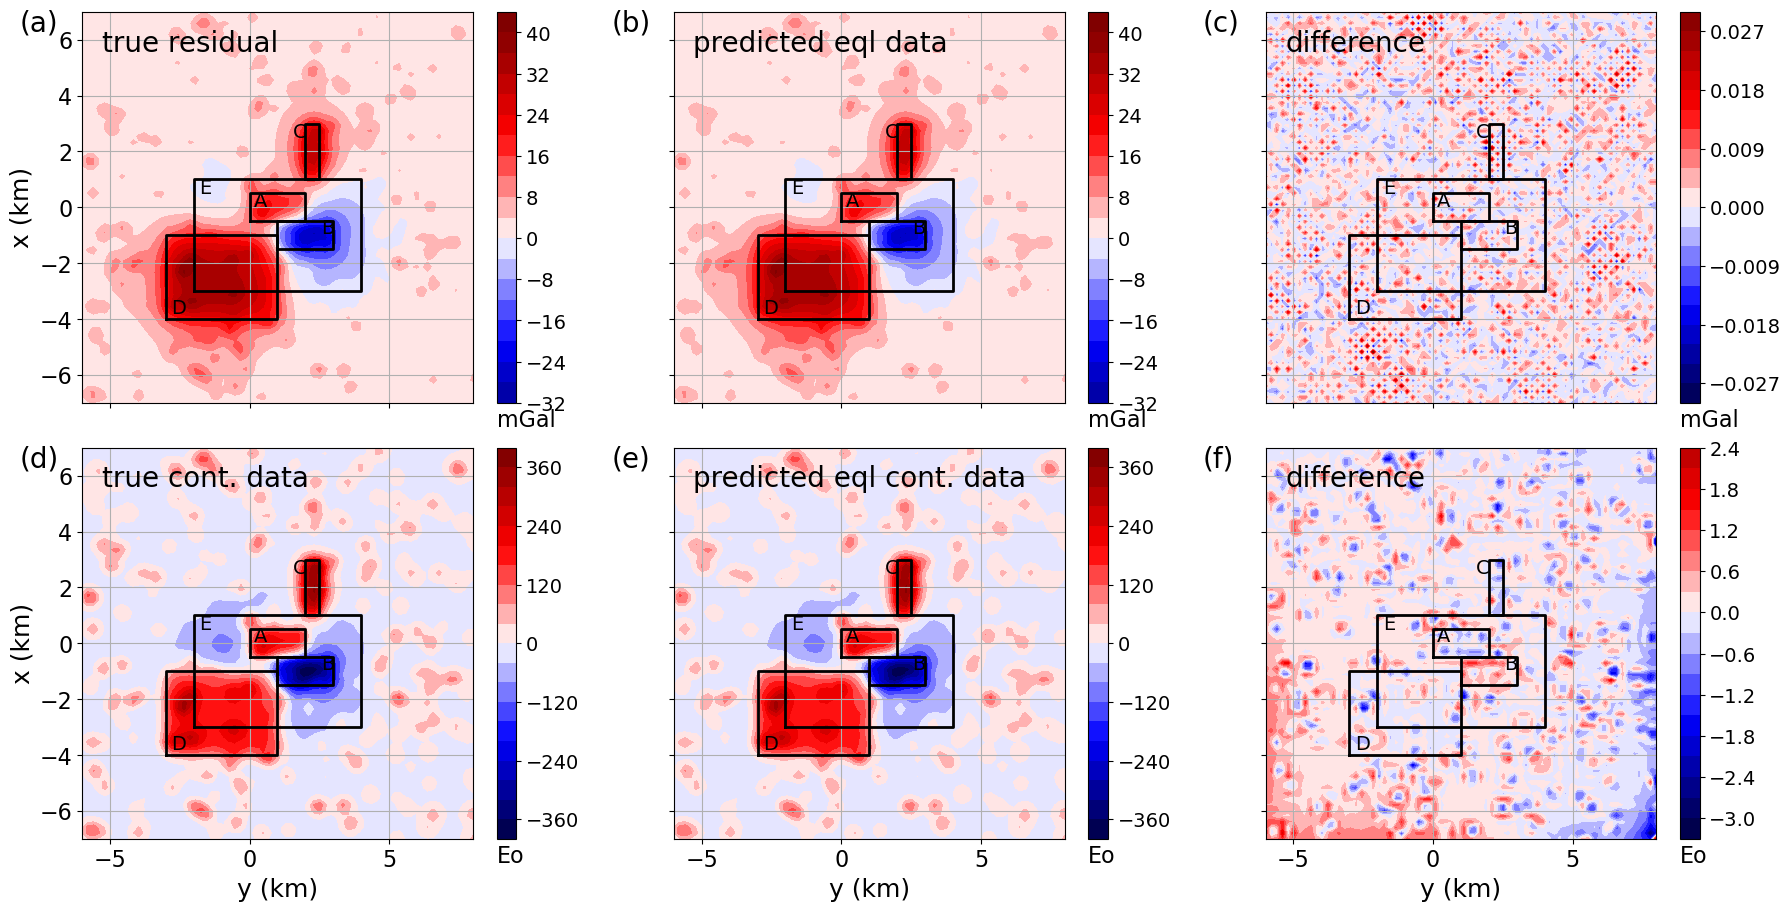

In [44]:
fig = plt.figure(layout= 'constrained', figsize=(18,9))
mosaic = fig.subplot_mosaic('''
                            abc
                            def
                            ''', sharex=True, sharey=True)

for (element, field, name, label, ranges_field, unit) in zip(
    mosaic_elements, 
    [
        gravity_data['gz'], predicted_data['gz'], predicted_data['gz'] - gravity_data['gz'],
        gravity_data_cont['zz'], predicted_data_cont['zz'], predicted_data_cont['zz'] - gravity_data_cont['zz']
    ], 
    names, 
    labels,
    ranges,
    unities
):

    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(Y*0.001, X*0.001, 
                     data_structures.grid_xy_full_flatten_to_matrix(
                         data=field,
                         grid_orientation=gravity_data['grid_orientation'],
                         shape=data_points['shape']
                     ), 20, 
                     cmap='seismic', vmin=-ranges_field, vmax=ranges_field)
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_xlabel(unit, fontsize=16, loc='left')
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)
    ax.annotate(name, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=20)
    plf.model_boundaries(
        ax,
        model=model_cut(model['prisms'], pmin=0, pmax=4),
        color=color,
        style='-',
        width='2'
    )
    ax.annotate(text='A', xy=(0.15, 0.05), fontsize=14, color=color)
    ax.annotate(text='B', xy=(2.55, -0.95), fontsize=14, color=color)
    ax.annotate(text='C', xy=(1.55, 2.50), fontsize=14, color=color)
    ax.annotate(text='D', xy=(-2.80, -3.80), fontsize=14, color=color)
    ax.annotate(text='E', xy=(-1.80, 0.50), fontsize=14, color=color)

for element in ['a', 'd']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)

for element in ['d','e','f']:
    mosaic[element].set_xlabel('y (km)', fontsize=18)

plt.show()

## Estimate the equivalent layer - estimated residual data

In [45]:
# estimate the equivalent layer
convergence, layer = eqlayer.method_iterative_deconvolution_TOB20(
    eigenvalues_matrices=[L_Gradient],
    data_vectors=[estimated_residual],
    epsilon=1e-7,
    ITMAX=200
)

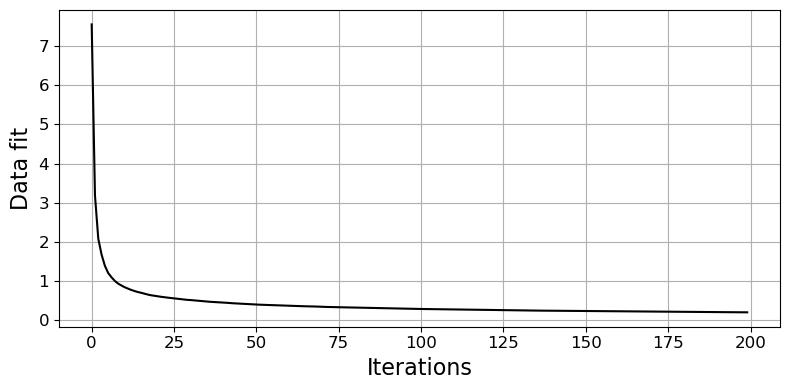

In [46]:
fig, ax = plt.subplots(figsize=(8,4))

iterations = [i for i in range(len(convergence))]
ax.plot(
    iterations, convergence, linestyle='-', c='k', alpha=1, markersize=4
)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Iterations', fontsize=16)
ax.set_ylabel('Data fit', fontsize=16)
ax.grid(True)
plt.tight_layout()
plt.show()

## Compute the predicted data

In [47]:
predicted_data = {
    'gz': convolve.product_BCCB_vector(
        eigenvalues = L_Gradient,
        ordering = 'row',
        v = layer
    )
}

## Compute the upward continuation

In [48]:
predicted_data_cont = {
    'gz': convolve.product_BCCB_vector(
        eigenvalues = L_Gradient,
        ordering = 'row',
        v = layer
    )
}

## Plot the results

In [49]:
names = [
    'est. residual', 'predicted eql data', 'difference',
    'true cont. data', 'predicted eql cont. data', 'difference'
]
labels = [
    '(a)', '(b)', '(c)',
    '(d)', '(e)', '(f)'
]

In [50]:
mosaic_elements = [
    'a', 'b', 'c', 
    'd', 'e', 'f'
]

In [51]:
color = 'k'#3*(0.4,)

In [52]:
ranges_data = np.max(np.abs([predicted_data['gz'], estimated_residual]))
ranges_data_cont = np.max(np.abs([gravity_data_cont['gz'], predicted_data_cont['gz']]))

ranges = [
    ranges_data, ranges_data, np.max(np.abs(predicted_data['gz'] - estimated_residual)),
    ranges_data_cont, ranges_data_cont, np.max(np.abs(predicted_data_cont['gz'] - gravity_data_cont['gz'])),
]

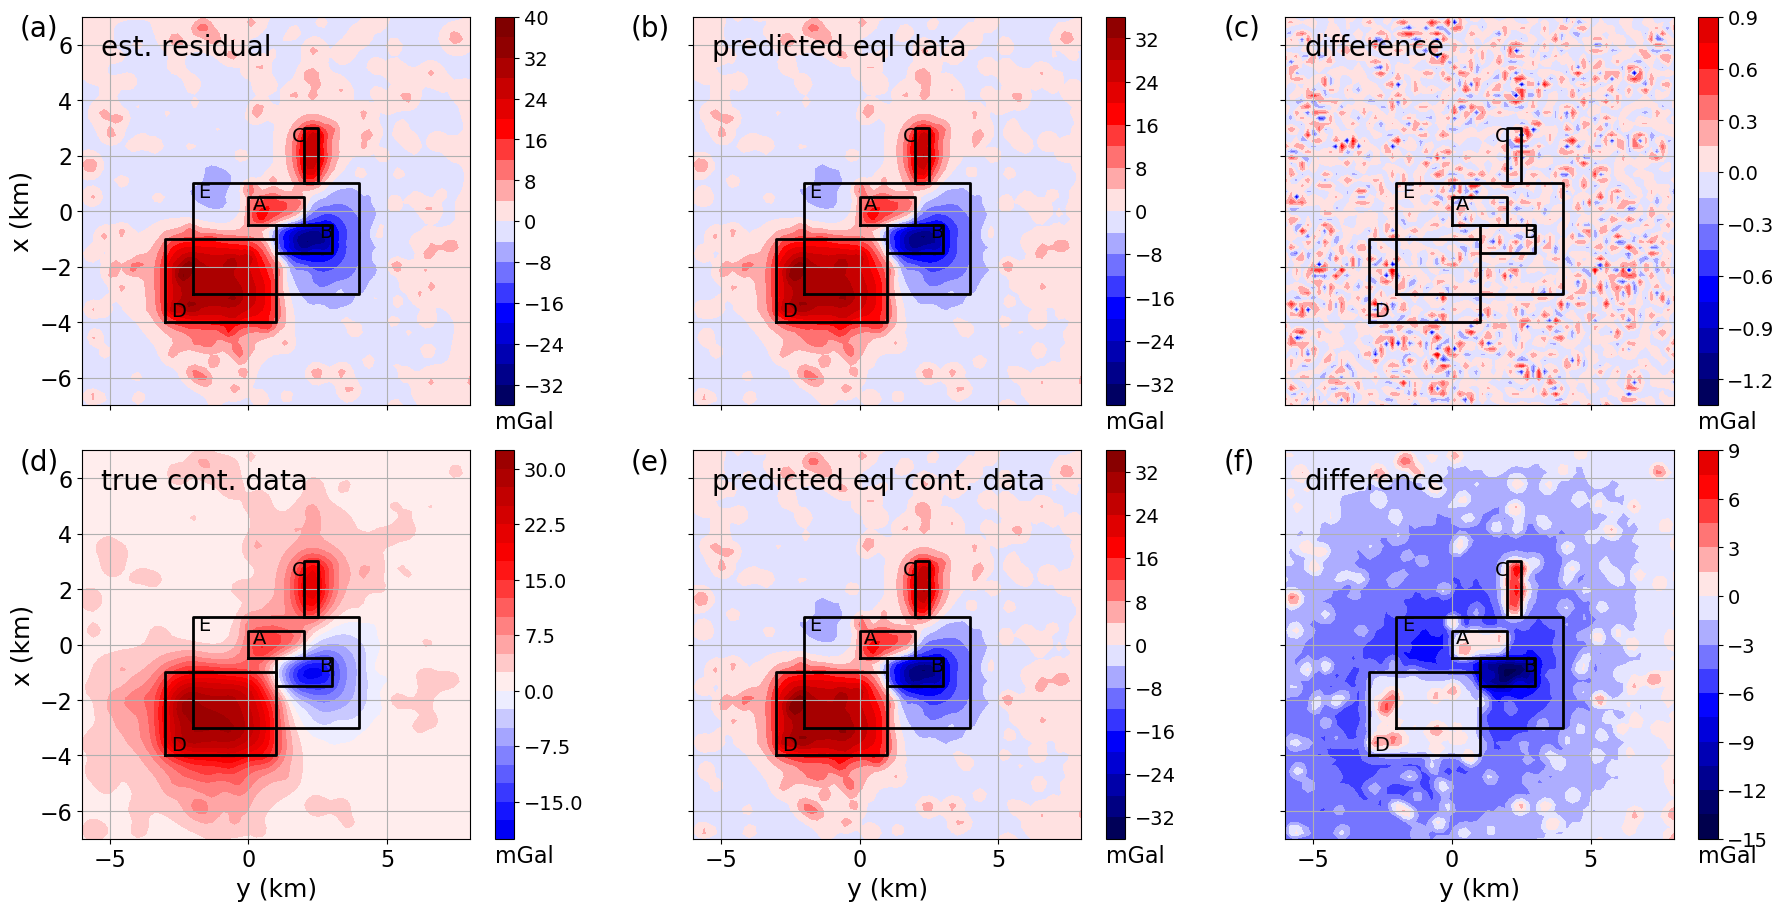

In [53]:
fig = plt.figure(layout= 'constrained', figsize=(18,9))
mosaic = fig.subplot_mosaic('''
                            abc
                            def
                            ''', sharex=True, sharey=True)

for (element, field, name, label, ranges_field) in zip(
    mosaic_elements, 
    [
        estimated_residual, predicted_data['gz'], predicted_data['gz'] - estimated_residual,
        gravity_data_cont['gz'], predicted_data_cont['gz'], predicted_data_cont['gz'] - gravity_data_cont['gz']
    ], 
    names, 
    labels,
    ranges
):

    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(Y*0.001, X*0.001, 
                     data_structures.grid_xy_full_flatten_to_matrix(
                         data=field,
                         grid_orientation=gravity_data['grid_orientation'],
                         shape=data_points['shape']
                     ), 20, 
                     cmap='seismic', vmin=-ranges_field, vmax=ranges_field)
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_xlabel('mGal', fontsize=16, loc='left')
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)
    ax.annotate(name, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=20)
    plf.model_boundaries(
        ax,
        model=model_cut(model['prisms'], pmin=0, pmax=4),
        color=color,
        style='-',
        width='2'
    )
    ax.annotate(text='A', xy=(0.15, 0.05), fontsize=14, color=color)
    ax.annotate(text='B', xy=(2.55, -0.95), fontsize=14, color=color)
    ax.annotate(text='C', xy=(1.55, 2.50), fontsize=14, color=color)
    ax.annotate(text='D', xy=(-2.80, -3.80), fontsize=14, color=color)
    ax.annotate(text='E', xy=(-1.80, 0.50), fontsize=14, color=color)

for element in ['a', 'd']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)

for element in ['d','e','f']:
    mosaic[element].set_xlabel('y (km)', fontsize=18)

plt.show()